In [6]:
%pylab notebook
from glob import glob

def draw(gid, x_o=0, y_o=0, bb=False, add_label=False, label=None):
    ''' draw a glyp at certain position '''
    gg = glyphs[gid]
#     w = gg[-1]
    
    l, r = gg[0:2]
#     print(l, r)
    xx = gg[0::2][1:].astype(float)
    yy = gg[1::2][1:].astype(float)
    
    g_inds = (xx == -50) & (yy == 0)
    xx[g_inds] = nan
    yy[g_inds] = nan
    
    x_o -= l
    
    plot(xx + x_o, -yy + y_o, '-', lw=1)
    if bb:
        vlines([0 + x_o], y_o - 20, y_o - 15, color='red')
        vlines([l + x_o], y_o - 20, y_o - 15, color='grey')
        vlines([r + x_o], y_o - 20, y_o - 15, color='grey')
    if add_label:
        if label is None:
            label = f'{gid:04x}'
        text(x_o, y_o - 30, label, color='grey', ha='center', size="x-small")
    return r - l

def expand_range(mm):
    ''' expand a font mapping containing ranges '''
    if type(mm) is str:
        mm = mm.replace('\n', ' ').split()
    mm_ = []
    for m in mm:
        if '-' in m:
            tmp = m.split('-')
            rr = range(int(tmp[0]), int(tmp[1]) + 1)
            mm_ += rr
        else:
            mm_.append(int(m))
    return mm_

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['draw', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Load hershey glyphs

In [2]:
with open('./hershey') as f:
    lines_ = f.readlines()

lines = []
for d in lines_:
    d = d.rstrip('\n')
    try:
        k = int(d[0:5])  # glyph id
        n = int(d[5:8])  # number of vertices
        lines.append(d)
    except ValueError:
        if len(d) > 0:
            lines[-1] += d
print(len(lines_), len(lines))

glyphs = {}
for d in lines:
    k = int(d[0:5])  # glyph id
    n = int(d[5:8])  # number of vertices
    tmp = [ord(c) - ord('R') for c in d[8:]]
    assert(len(tmp) == n * 2)
    # we do width at the end     
#     l, r, *tmp_ = tmp
#     tmp_.append(r - l)
    glyphs[k] = array(tmp)

2324 1597


# Plot ALL glyphs

<IPython.core.display.Javascript object>


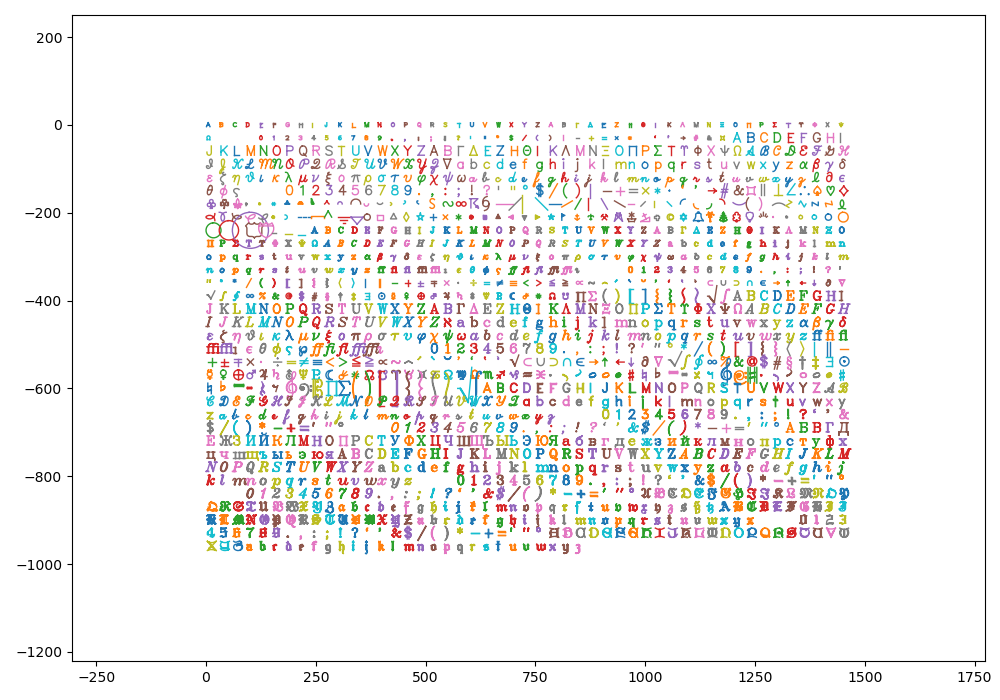

In [5]:
close('all')
figsize(10, 7)
axis('equal')

xp = 0
yp = 0
stp = 30
for k in sorted(glyphs.keys()):
    r = draw(k, xp, yp)
    xp += stp
    if (xp > stp * 48):
        xp = 0
        yp -= stp
tight_layout()

# Load all font mappings

In [3]:
remaining_keys = set(glyphs.keys())

maps = {}
for fn in glob("ascii-mapping/*.hmp"):
    with open(fn) as f:
        dat = expand_range(f.read(-1))
    fn_ = fn.split('/')[-1][:-4]
    maps[fn_] = dat
    remaining_keys.difference_update(dat)

maps["symbols"] = sorted(remaining_keys)
    
maps.keys()

dict_keys(['italict', 'romancs', 'romand', 'scriptc', 'romanp', 'romant', 'greekcs', 'romanc', 'italiccs', 'gothgrt', 'romans', 'greekp', 'cyrilc', 'gothgbt', 'italicc', 'greeks', 'scripts', 'greekc', 'gothitt', 'symbols'])

# Plot index sheets

<IPython.core.display.Javascript object>


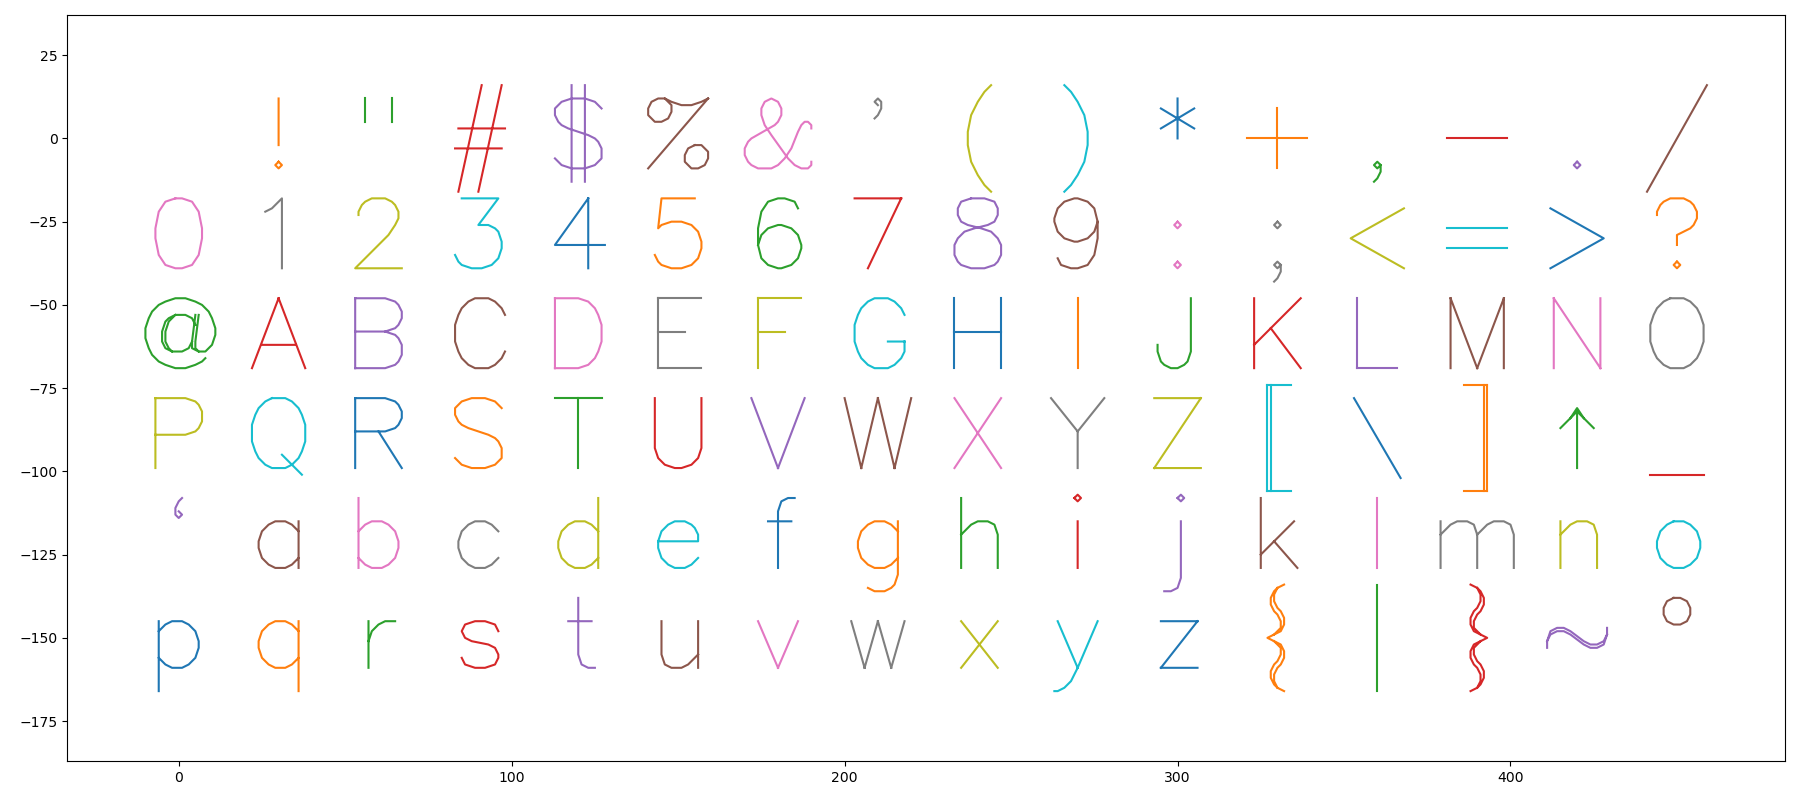

In [190]:
for m in maps.keys():
#     m = 'romans'
    figure()
    figsize(18, 8)
    axis('equal')
    tight_layout()

    xp = 0
    yp = 0
    stp = 30
    for k in maps[m]:
        r = draw(k, xp, yp)
        xp += stp
        if (xp >= stp * 16):
            xp = 0
            yp -= stp
#     break
    savefig(f'ascii-mapping/{m}.png')

# Leftovers (symbols)

<IPython.core.display.Javascript object>


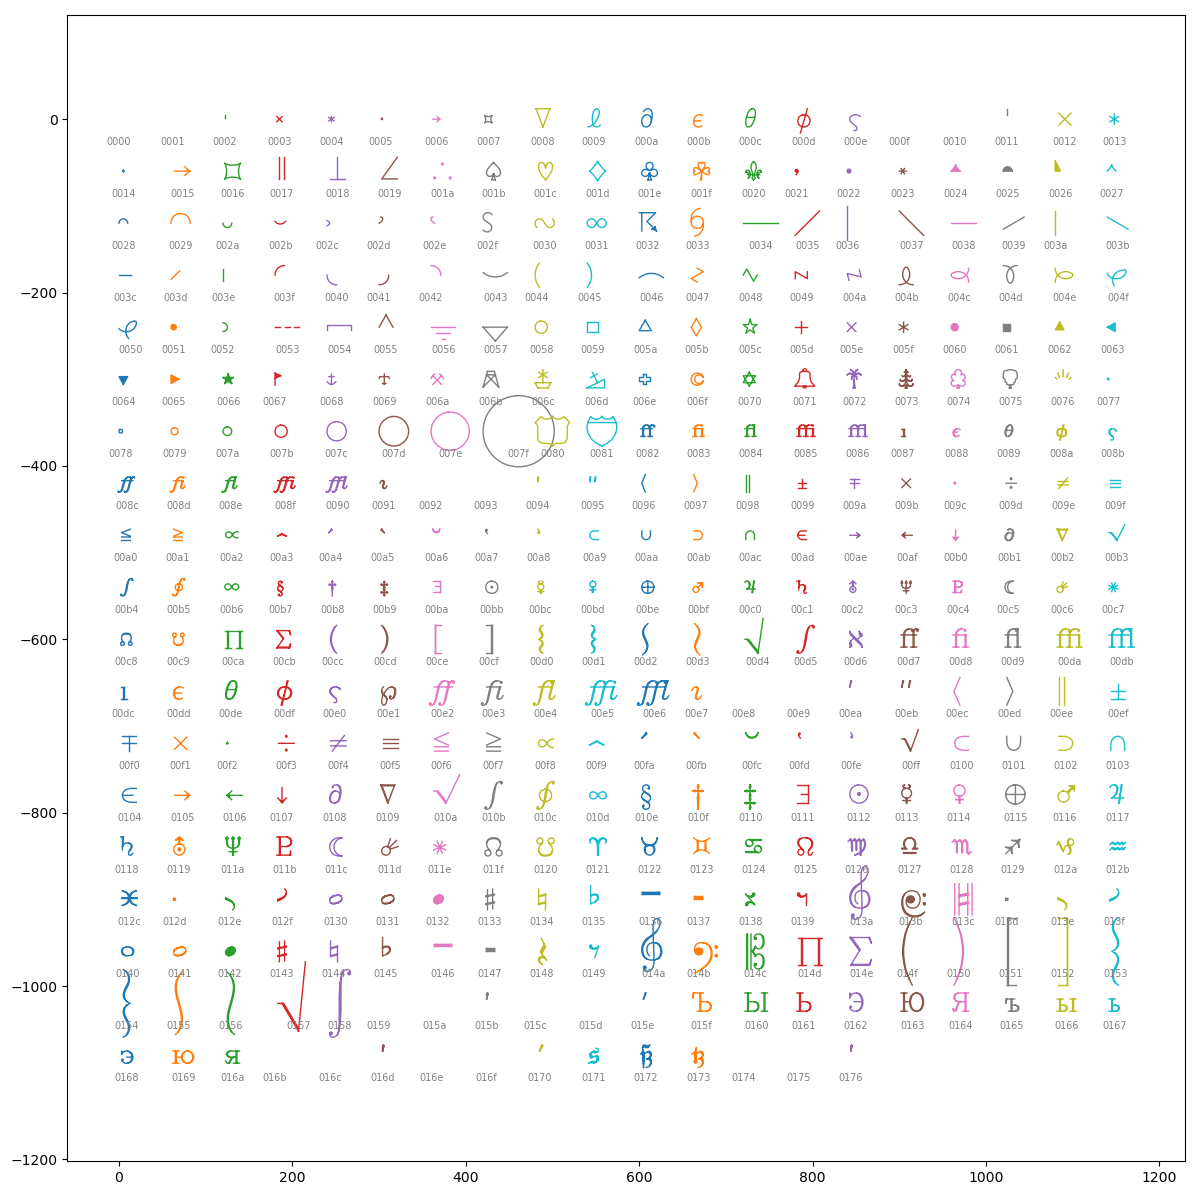

In [8]:
figure()
figsize(12, 12)
axis('equal')
tight_layout()

xp = 0
yp = 0
stp = 60
for i, k in enumerate(maps["symbols"]):
    r = draw(k, xp, yp, add_label=True, label=f'{i:04x}')
    xp += stp
    if (xp >= stp * 20):
        xp = 0
        yp -= stp
#     break
# savefig(f'ascii-mapping/remaining.png', dpi=300)

# Test spacing between glyphs

The cursor is at the left edge of the glyph.

We move by -l to reach the center

We draw the glyph

We move by r to reach the right edge of the glyph

/tmp/ipykernel_12412/4089308141.py:1: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  close('all')


<IPython.core.display.Javascript object>


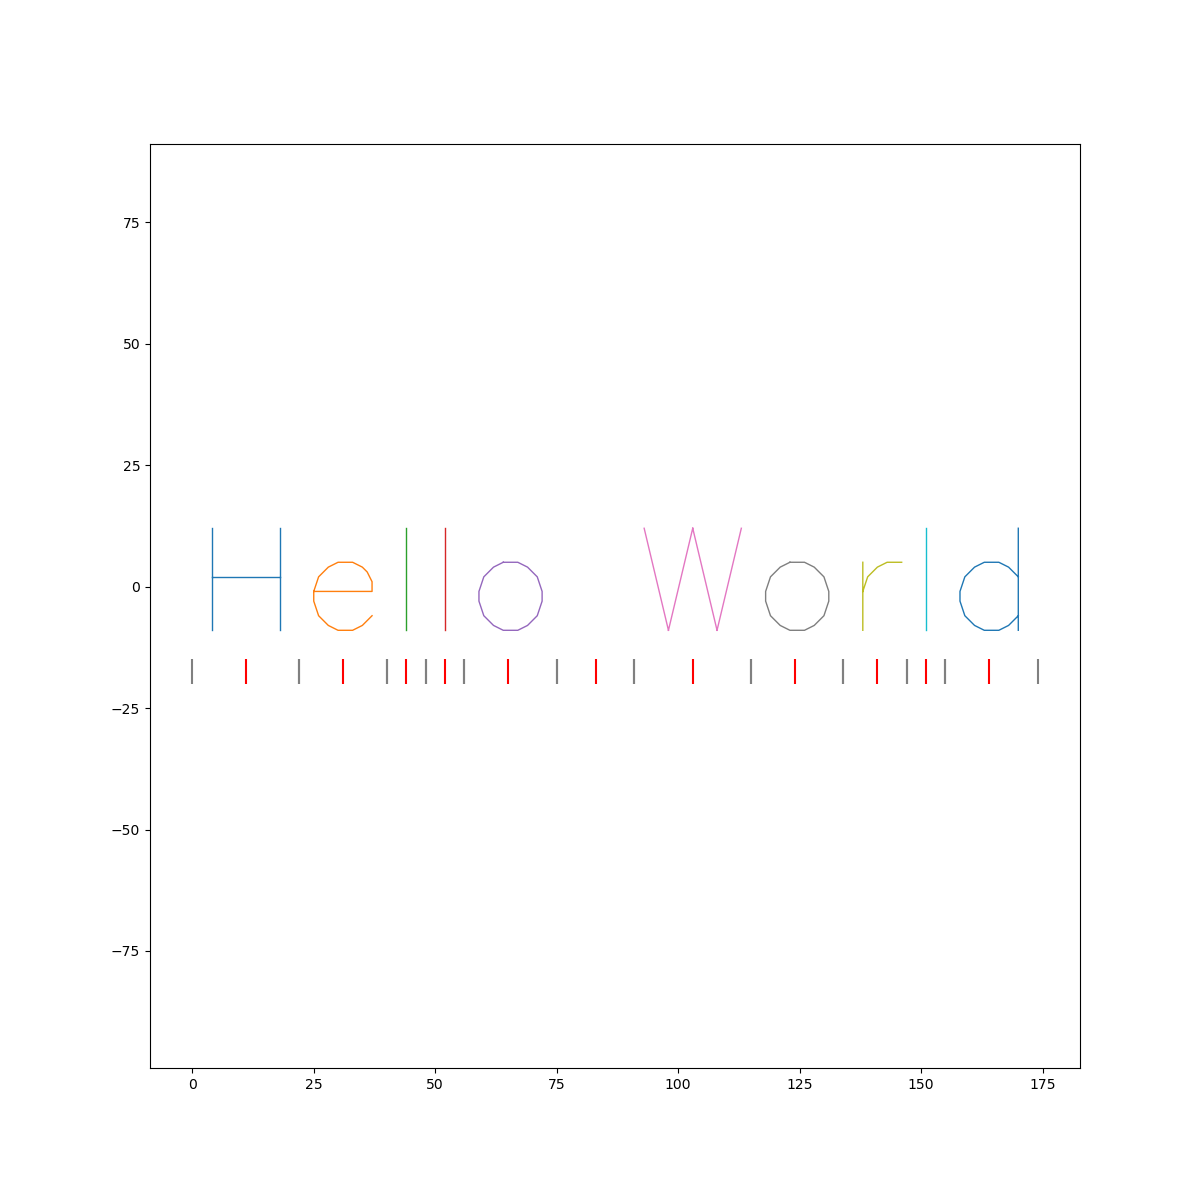

In [9]:
close('all')
axis('equal')

m = maps['romans']

x_o = 0
for c in "Hello World":
    r = draw(m[ord(c) - 0x20], x_o, 0, bb=True)
    x_o += r

# C-code generation

In [10]:
from font_helpers import CoordinateEncoder, T_GOTO, T_LINETO, print_table

In [11]:
to_export = [
#     'cyrilc',
#    'gothgbt',
#    'gothgrt',
#    'gothitt',
#     'greekc',
#     'greekcs',
#     'greekp',
#     'greeks',
#    'italicc',
    'italiccs',
#    'italict',
#    'romanc',
    'romancs',
#    'romand',
#    'romanp',
    'romans',
#    'romant',
    'scriptc',
    'scripts',
    'symbols'
]

In [12]:
def gen_c_file(name, gs):
    all_bs = bytes()
    glyph_props = []

    for gl_index in gs:
        ce = CoordinateEncoder()

        pts = glyphs[gl_index]
        l, r = pts[0:2]
        cmd = T_GOTO
        bs = bytes()

        for pt in pts[2:].reshape([-1, 2]):
            if (pt == (-50, 0)).all():
                cmd = T_GOTO
                continue

            xx = pt[0] - l
            yy = -pt[1]
            bs += ce.encode((xx, yy), cmd << 4)
            
            cmd = T_LINETO

        glyph_props.append({
            "end_index": len(all_bs) + len(bs),
            "adv_w": r - l,
        })
        all_bs += bs

    with open(f"hershey_{name}.c", 'w') as f:
        print(f'''\
#include <stdint.h>
#include <stdio.h>
#include <font_draw.h>
// -----------------------------------
//  Hershey font, {name}
// -----------------------------------

static const uint8_t glyphs_{name}[{len(all_bs)}] = {{''', file=f)
        print_table(all_bs, f=f)
    
        print(f'''\
// GLYPH DESCRIPTION
static const glyph_dsc_t glyph_dsc_{name}[{len(glyph_props)}] = {{''', file=f)
        for line in glyph_props:
            print("    {" + ", ".join([f'.{k} = {v:5d}' for k, v in line.items()]) + f"}},", file=f)
        print("};\n", file=f)

        print(f'''\
const font_t f_hershey_{name} = {{
    .units_per_em = 28,
    .n_glyphs = {len(glyph_props)},
    .glyphs = glyphs_{name},
    .glyph_dsc = glyph_dsc_{name},
    .map_start = {0 if name == 'symbols' else 0x20},
    .map_n = {len(glyph_props)},
    .map_unicode_table = NULL
}};''', file=f)
    
    # unicode mapping tables
#     n_cp_table_entries = len(cp_set) - n_ascii
#     cp_table_name = "NULL"
#     if n_cp_table_entries > 0:
#         cp_table_name = f"code_points_{name}"
#         print(f'const unsigned {cp_table_name}[{n_cp_table_entries}] = {{', file=f)
#         print_table(cp_set[n_ascii:], w=19, w_v=6, f=f)

    print("wrote", f.name)

In [13]:
for name in to_export:
    gs = maps[name]
    gen_c_file(name, gs)

wrote hershey_italiccs.c
wrote hershey_romancs.c
wrote hershey_romans.c
wrote hershey_scriptc.c
wrote hershey_scripts.c
wrote hershey_symbols.c
